In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import arsenal.profiling
from collections import deque
from arsenal import timers

from transduction.lazy import Lazy
from transduction.fsa import FSA, EPSILON
from transduction import (
    FST, EPSILON, PrecoverDecomp, examples, Precover,    
)
from time import time
from collections import Counter
from transduction.util import display_table
from transduction.precover_nfa import PrecoverNFA as LazyPrecoverNFA
from transduction.dfa_decomp_nonrecursive import NonrecursiveDFADecomp
from transduction.applications.bpe import Token, bpe_wfst

In [3]:
from transduction.lm.statelm import decode_hf_tokenizer
from transformers import AutoTokenizer

# PTB Tokenizer Scaling Benchmark

Compares decomposition and LM algorithms on the Penn Treebank tokenizer FST
(~296 states, 257 input symbols).  All calls are guarded by per-call timeouts
(via `signal.alarm`) and a process-wide memory limit.

In [4]:
import signal, resource, time, gc
import numpy as np

# ---- Safety: memory limit (8 GB virtual address space) ----
_GB = 1024 ** 3
_soft, _hard = resource.getrlimit(resource.RLIMIT_AS)
resource.setrlimit(resource.RLIMIT_AS, (8 * _GB, _hard))

class _Timeout(Exception):
    pass

def _alarm(signum, frame):
    raise _Timeout()

def timed(fn, timeout_s=30, label=''):
    """Run fn() with wall-clock timeout. Returns (result, elapsed_s) or (None, None)."""
    prev = signal.signal(signal.SIGALRM, _alarm)
    signal.alarm(timeout_s)
    try:
        t0 = time.perf_counter()
        out = fn()
        return out, time.perf_counter() - t0
    except _Timeout:
        print(f'  {label} TIMEOUT ({timeout_s}s)')
        return None, None
    except MemoryError:
        print(f'  {label} OOM')
        return None, None
    except Exception as e:
        print(f'  {label} ERROR: {type(e).__name__}: {e}')
        return None, None
    finally:
        signal.alarm(0)
        signal.signal(signal.SIGALRM, prev)

# ---- Remap multi-char PTB symbols to single Unicode chars ----
# PeekabooPrecover NFA uses string concatenation for buffers and indexes by
# character position, which breaks for multi-character symbol names like '84'.
def remap_fst_to_single_chars(fst):
    from transduction.fst import FST as FSTClass
    from transduction.fsa import EPSILON as _EPS
    fwd, inv = {}, {}
    code = 0xE000  # Unicode private-use area
    for sym in sorted(fst.A | fst.B):
        if sym == _EPS:
            continue
        fwd[sym] = chr(code)
        inv[chr(code)] = sym
        code += 1
    new_fst = FSTClass()
    for s in fst.start: new_fst.add_start(s)
    for s in fst.stop:  new_fst.add_stop(s)
    for s in fst.states:
        for x, y, j in fst.arcs(s):
            new_x = fwd.get(x, x) if x != _EPS else _EPS
            new_y = fwd.get(y, y) if y != _EPS else _EPS
            new_fst.add_arc(s, new_x, new_y, j)
    return new_fst, fwd, inv

# ---- Build PTB FST (requires pynini) ----
from transduction.applications.ptb import build_ptb_fst_pynini, string_to_byte_strs, decode_ptb_output
from transduction.fst import FST
from transduction.fsa import EPSILON

t0 = time.perf_counter()
raw_fst = build_ptb_fst_pynini()
ptb_fst, fwd_map, inv_map = remap_fst_to_single_chars(raw_fst)
print(f'PTB FST built in {time.perf_counter()-t0:.1f}s: '
      f'{len(ptb_fst.states)} states, |A|={len(ptb_fst.A)}, |B|={len(ptb_fst.B)}')

# Generate target sequence
text = "The quick brown fox jumps over the lazy dog."
byte_strs = string_to_byte_strs(text)
remapped_input = tuple(fwd_map[s] for s in byte_strs)
input_fst_obj = FST.from_string(remapped_input)
output_fsa = (input_fst_obj @ ptb_fst).project(1)
target_seq = list(next(output_fsa.language(tuple=True)))
decoded = decode_ptb_output(tuple(inv_map.get(c, c) for c in target_seq))
print(f'Target: {len(target_seq)} symbols')
print(f'  {decoded!r}')

# Train inner LM for TransducedLM benchmarks
from transduction.lm.ngram import CharNgramLM
source_alpha = ptb_fst.A - {EPSILON}
train_text = (
    "The quick brown fox jumps over the lazy dog. "
    "A stitch in time saves nine. To be or not to be, that is the question. "
    "All that glitters is not gold. Actions speak louder than words. "
    "Practice makes perfect. Where there is a will, there is a way. "
) * 3
train_syms = [fwd_map[s] for s in string_to_byte_strs(train_text)]
for sym in source_alpha:
    train_syms.append(sym)
inner_lm = CharNgramLM.train(train_syms, n=3, alpha=0.5)
print(f'Inner LM: alphabet={len(inner_lm.alphabet)} symbols')

Composing PTB rules...
Core PTB FST: 310 states
Final pynini FST: 296 states
Converting to native FST...
Native FST: 296 states, 23723 arcs
  eps: 108 in, 352 out
  MARKER: 0 in, 0 out
  [EOS]: 0 in, 0 out
PTB FST built in 33.7s: 296 states, |A|=257, |B|=256
Target: 45 symbols
  'The quick brown fox jumps over the lazy dog .'
Inner LM: alphabet=257 symbols


## Decomposition Scaling

Per-step cost of computing decomposition at increasing target lengths.

**Next-symbol prediction** (compute Q/R for all ~256 possible next output symbols):
- **PeekabooState** (incremental, truncated buffer): chains `>>` + `.decomp`
- **Peekaboo NR** (non-recursive, truncated buffer): fresh computation each step

**Single-target decomposition** (Q/R for one specific target string):
- **NonrecursiveDFADecomp** (unbounded buffer)

Note: the next-symbol algorithms time out quickly on PTB because the powerset DFA
with 256 output symbols is enormous.  NonrecursiveDFADecomp scales well because it
only classifies states for a single target and prunes via universality.

In [5]:
from collections import defaultdict
from transduction.peekaboo_incremental import PeekabooState, FstUniversality
from transduction.peekaboo_nonrecursive import Peekaboo as PeekabooNR
from transduction.dfa_decomp_nonrecursive import NonrecursiveDFADecomp

MAX_N = min(25, len(target_seq))
DECOMP_TIMEOUT = 30        # seconds per step (decomp-only algorithms)
NEXTSYM_TIMEOUT = 120      # seconds per step (next-symbol algorithms — these are slow on PTB)

decomp_results = defaultdict(list)  # name -> [(step, time_s)]

# --- PeekabooState (incremental, next-symbol) ---
# Computes decomposition for ALL ~256 next symbols simultaneously.
# On PTB this is very slow (DFA state space explodes with 256 output symbols).
print('PeekabooState (incremental, next-symbol):')
univ = FstUniversality(ptb_fst)
ps = PeekabooState(ptb_fst, '', parent=None, univ=univ)
for i in range(min(5, MAX_N)):  # cap at 5 steps — each is very slow
    y = target_seq[i]
    def step(s=ps, y=y):
        s2 = s >> y
        _ = s2.decomp
        return s2
    out, t = timed(step, timeout_s=NEXTSYM_TIMEOUT, label=f'step {i+1}')
    if t is None:
        break
    ps = out
    decomp_results['PeekabooState'].append((i + 1, t))
    print(f'  {i+1:2d}: {t*1000:8.1f} ms')
gc.collect()

# --- Peekaboo nonrecursive (next-symbol) ---
print('\nPeekaboo (nonrecursive, next-symbol):')
for i in range(min(5, MAX_N)):
    prefix = ''.join(target_seq[:i + 1])
    def compute(p=prefix):
        obj = PeekabooNR(ptb_fst, p)
        _ = obj._results
        return obj
    _, t = timed(compute, timeout_s=NEXTSYM_TIMEOUT, label=f'step {i+1}')
    if t is None:
        break
    decomp_results['PeekabooNR'].append((i + 1, t))
    print(f'  {i+1:2d}: {t*1000:8.1f} ms')
gc.collect()

# --- NonrecursiveDFADecomp (single-target) ---
# Computes Q/R for ONE specific target string.  Much faster because universality
# pruning terminates the BFS early.
print('\nNonrecursiveDFADecomp (single-target):')
for i in range(MAX_N):
    prefix = ''.join(target_seq[:i + 1])
    def compute(p=prefix):
        return NonrecursiveDFADecomp(ptb_fst, p)
    _, t = timed(compute, timeout_s=DECOMP_TIMEOUT, label=f'step {i+1}')
    if t is None:
        break
    decomp_results['NonrecursiveDFADecomp'].append((i + 1, t))
    print(f'  {i+1:2d}: {t*1000:8.1f} ms')
gc.collect()

PeekabooState (incremental, next-symbol):
  step 1 TIMEOUT (120s)

Peekaboo (nonrecursive, next-symbol):
   1:  93626.7 ms
   2:  87560.3 ms
   3:  93883.2 ms
   4:  40216.5 ms
   5:  88540.9 ms

NonrecursiveDFADecomp (single-target):
   1:   1894.0 ms
   2:   1849.0 ms
   3:   1882.3 ms
   4:   3672.5 ms
   5:   1709.1 ms
   6:   1722.1 ms
   7:   1950.3 ms
   8:   1770.2 ms
   9:   1780.7 ms
  10:   3360.3 ms
  11:   1755.6 ms
  12:   1854.4 ms
  13:   1840.7 ms
  14:   1913.4 ms
  15:   4189.5 ms
  16:   3304.5 ms
  17:   1679.7 ms
  18:   1688.3 ms
  19:   1806.0 ms
  20:   3456.0 ms
  21:   1736.5 ms
  22:   1742.9 ms
  23:   1664.0 ms
  24:   1767.4 ms
  25:   1765.4 ms


0

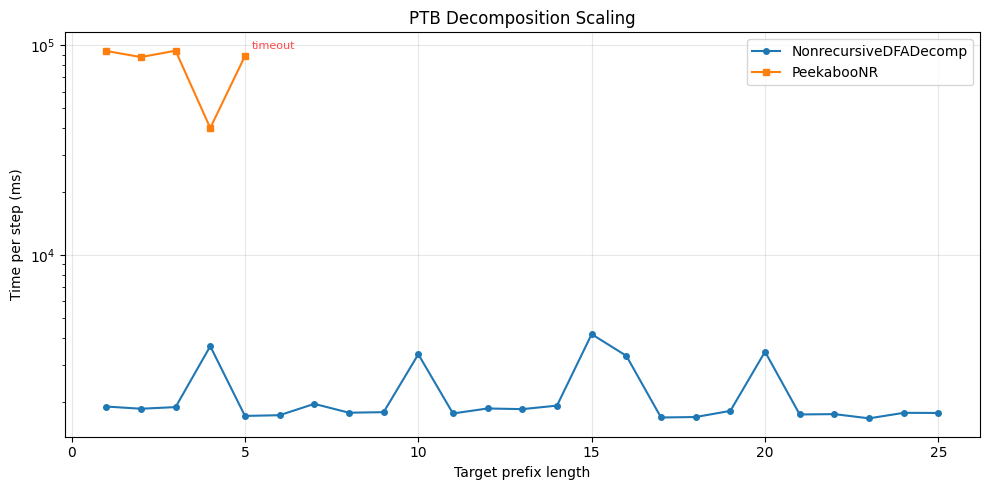

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
markers = iter(['o', 's', '^', 'D', 'v', 'P'])
for name, data in sorted(decomp_results.items()):
    if not data:
        print(f'{name}: no data (timed out on first step)')
        continue
    steps, times = zip(*data)
    ax.plot(steps, [t * 1000 for t in times], marker=next(markers, 'o'),
            linestyle='-', label=name, markersize=4)
    if len(data) < MAX_N:
        ax.annotate(f'timeout', xy=(steps[-1], times[-1]*1000),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, color='red', alpha=0.7)

ax.set_xlabel('Target prefix length')
ax.set_ylabel('Time per step (ms)')
ax.set_title('PTB Decomposition Scaling')
ax.legend()
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## TransducedLM Scaling

Per-step decode time for **TransducedLM** (two-phase: PeekabooState BFS
decomposition, then LM-weighted search) vs **FusedTransducedLM** (single-pass:
interleaved decomposition + LM search, no separate BFS).

Each step includes both decomposition and LM search costs.  For TransducedLM,
the PeekabooState BFS dominates (~35s per step on PTB).  FusedTransducedLM
avoids the BFS entirely but builds the lazy DFA inline during search.

Both use `max_steps=200`, `max_beam=100`, with a 120s timeout per step.

In [ ]:
from transduction.lm.transduced import TransducedLM
from transduction.lm.fused_transduced import FusedTransducedLM

MAX_DECODE = 10              # number of decode steps
MAX_SEARCH = 200             # max priority-queue steps per logp_next
MAX_BEAM = 100               # max items carried forward
LM_TIMEOUT = 120             # seconds per step

# Expected runtime: ~15-20 min total (TransducedLM ~65s/step, FusedTransducedLM ~35s/step)

lm_results = defaultdict(list)  # name -> [(step, time_s, logp)]

for name, cls in [('TransducedLM', TransducedLM),
                  ('FusedTransducedLM', FusedTransducedLM)]:
    print(f'\n{name} (max_steps={MAX_SEARCH}, max_beam={MAX_BEAM}):')
    tlm = cls(inner_lm, ptb_fst, max_steps=MAX_SEARCH, max_beam=MAX_BEAM)
    state = tlm.initial()
    for i in range(min(MAX_DECODE, len(target_seq))):
        y = target_seq[i]
        def step(s=state, y=y):
            lp = s.logp_next[y]
            return s >> y, lp
        out, t = timed(step, timeout_s=LM_TIMEOUT, label=f'step {i+1}')
        if t is None:
            break
        state, lp = out
        lm_results[name].append((i + 1, t, lp))
        print(f'  {i+1:2d}: {t*1000:8.1f} ms  logp={lp:.4f}')
    gc.collect()

# Summary table
print(f'\n{"Algorithm":<25s} {"Total (s)":>10s} {"Avg/step (s)":>12s} {"Steps":>6s}')
print('-' * 55)
for name, data in sorted(lm_results.items()):
    total = sum(t for _, t, _ in data)
    avg = total / len(data)
    print(f'{name:<25s} {total:10.1f} {avg:12.1f} {len(data):6d}')
if len(lm_results) == 2:
    names = sorted(lm_results.keys())
    d0, d1 = lm_results[names[0]], lm_results[names[1]]
    t0 = sum(t for _, t, _ in d0)
    t1 = sum(t for _, t, _ in d1)
    if t1 > 0:
        print(f'\nFused speedup (overall): {t0/t1:.2f}x')
    # Exclude step 1 (amortization penalty for Fused)
    if len(d0) > 1 and len(d1) > 1:
        t0_skip1 = sum(t for _, t, _ in d0[1:])
        t1_skip1 = sum(t for _, t, _ in d1[1:])
        if t1_skip1 > 0:
            print(f'Fused speedup (step 2+): {t0_skip1/t1_skip1:.2f}x')

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: time per step
ax = axes[0]
for name, data in sorted(lm_results.items()):
    steps = [d[0] for d in data]
    times = [d[1] for d in data]
    ax.plot(steps, times, 'o-', label=name, markersize=4)
ax.set_xlabel('Target step')
ax.set_ylabel('Time per step (s)')
ax.set_title(f'TransducedLM vs Fused (PTB, max_steps={MAX_SEARCH})')
ax.legend()
ax.grid(True, alpha=0.3)

# Right: per-step speedup
ax = axes[1]
if len(lm_results) == 2:
    names = sorted(lm_results.keys())
    d0, d1 = lm_results[names[0]], lm_results[names[1]]
    n = min(len(d0), len(d1))
    steps = [d0[i][0] for i in range(n)]
    speedups = [d0[i][1] / d1[i][1] if d1[i][1] > 0 else 0 for i in range(n)]
    colors = ['#2ecc71' if s > 1 else '#e74c3c' for s in speedups]
    ax.bar(steps, speedups, color=colors, alpha=0.7, edgecolor='white')
    ax.axhline(1.0, color='black', linestyle='--', linewidth=0.8)
    ax.set_xlabel('Target step')
    ax.set_ylabel('Speedup (Original / Fused)')
    ax.set_title('Per-step speedup (>1 = Fused faster)')
    ax.grid(True, alpha=0.3, axis='y')

    logp_diffs = [abs(d0[i][2] - d1[i][2]) for i in range(n)]
    print(f'Max |logp| diff: {max(logp_diffs):.6f}')

plt.tight_layout()
plt.show()


In [ ]:
# Restore original memory limit
resource.setrlimit(resource.RLIMIT_AS, (_soft, _hard))
print('Memory limit restored.')
